In [1]:
"""
This notebook analysis whether DINO distances can be used to predict reconstruction loss at certain token counts
"""

'\nThis notebook analysis whether DINO distances can be used to predict reconstruction loss at certain token counts\n'

In [2]:
import json
import matplotlib.pyplot as plt
import math
import numpy as np

In [3]:
# read dino distances:
with open("/BS/data_mani_compress/work/thesis/thesis/data/datasets/dino_distances/val_categorized/dino_nearest_centroid_distances.json") as f:
    dino_distances = json.load(f)

In [4]:
# read reconstruction losses
with open("/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_APG_on.json") as f:
    recon_losses = json.load(f)

In [5]:
dino_distances = dino_distances['images']  # get list of distances only

In [6]:
print(dino_distances[:10])  # print first 10 distances
print(recon_losses[:10])  # print first 10 reconstruction losses at

[{'index': 0, 'nearest_centroid': 642, 'dino_distance': 41.347412109375}, {'index': 1, 'nearest_centroid': 642, 'dino_distance': 27.435306549072266}, {'index': 2, 'nearest_centroid': 956, 'dino_distance': 39.60049057006836}, {'index': 3, 'nearest_centroid': 956, 'dino_distance': 24.087421417236328}, {'index': 4, 'nearest_centroid': 642, 'dino_distance': 27.714157104492188}, {'index': 5, 'nearest_centroid': 642, 'dino_distance': 28.097156524658203}, {'index': 6, 'nearest_centroid': 956, 'dino_distance': 22.40505599975586}, {'index': 7, 'nearest_centroid': 956, 'dino_distance': 27.911340713500977}, {'index': 8, 'nearest_centroid': 956, 'dino_distance': 27.929874420166016}, {'index': 9, 'nearest_centroid': 956, 'dino_distance': 26.05865478515625}]
[{'image_id': 0, 'k_value': 1, 'L1Loss': 0.19351771473884583, 'LPIPS': 0.6646087765693665, 'LPIPS_layers': [0.11964087188243866, 0.14834865927696228, 0.11373482644557953, 0.1480303555727005, 0.13485409319400787], 'DINOv2FeatureLoss': 0.525488018

Using loss_key=DINOv2FeatureLoss; ks=[1, 2, 4, 8, 16, 32, 64, 128, 256]


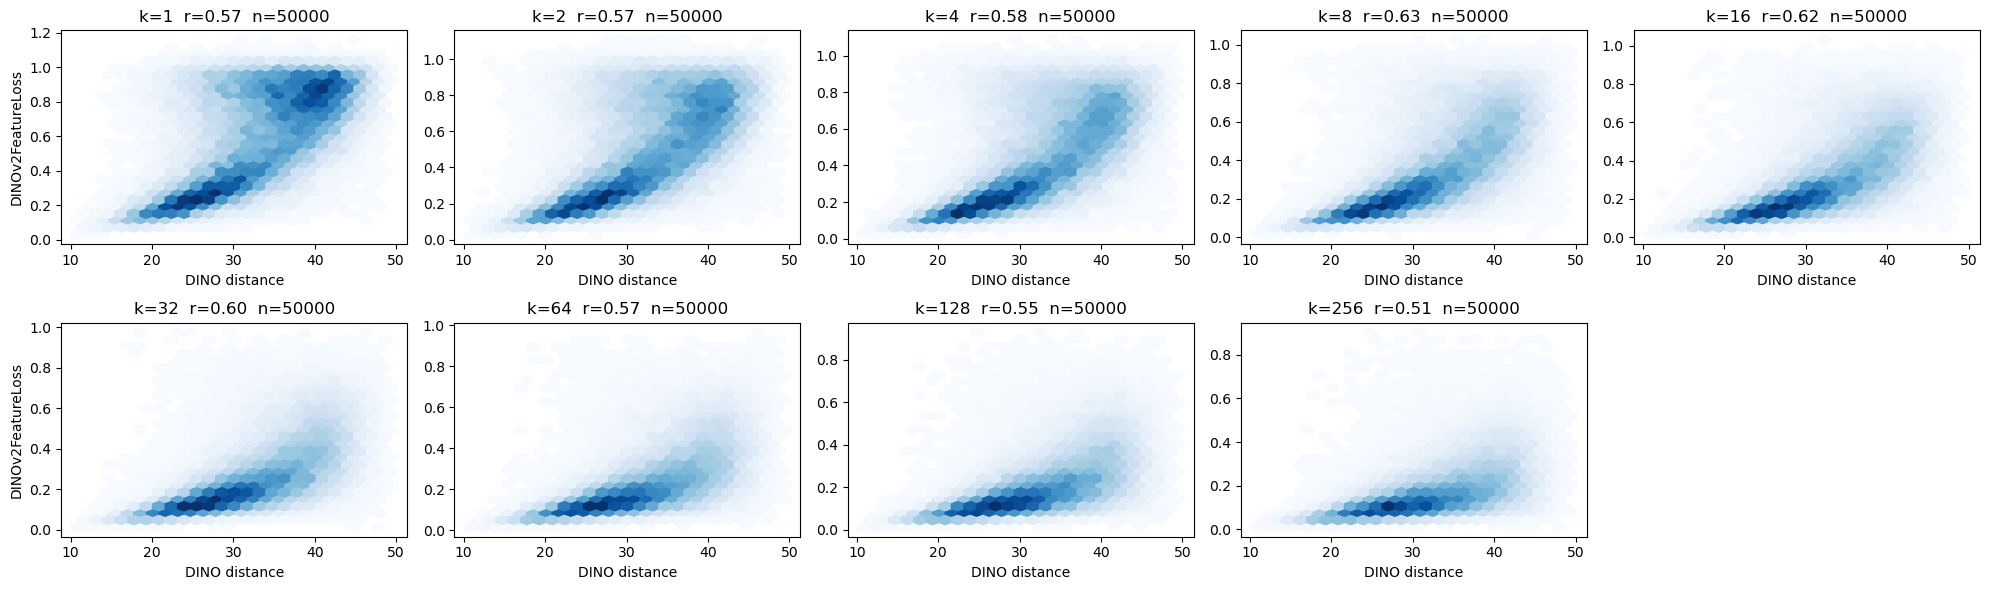

{1: {'n': 50000, 'pearson_r': 0.5699970016968727},
 2: {'n': 50000, 'pearson_r': 0.570660303021178},
 4: {'n': 50000, 'pearson_r': 0.5818650213604976},
 8: {'n': 50000, 'pearson_r': 0.6295086741228396},
 16: {'n': 50000, 'pearson_r': 0.6165319918685103},
 32: {'n': 50000, 'pearson_r': 0.5983942093446061},
 64: {'n': 50000, 'pearson_r': 0.5749157788720136},
 128: {'n': 50000, 'pearson_r': 0.5454879731283836},
 256: {'n': 50000, 'pearson_r': 0.5073967099356538}}

In [8]:
loss_key = 'DINOv2FeatureLoss'                 # or 'L1Loss' DINOv2FeatureLoss LPIPS
ks = [1, 2, 4, 8, 16, 32, 64, 128, 256]  # token counts to visualize
print(f"Using loss_key={loss_key}; ks={ks}")
corr_list = []

ncols = 5
nrows = int(math.ceil(len(ks) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), squeeze=False)
axes_f = axes.flatten()

per_k_stats = {}  # {k: {'n': count, 'pearson_r': r}}
for i, k in enumerate(ks):
    ax = axes_f[i]

    # Gather pairs (x=dino_distance, y=loss) for images that match this k and have a LID value
    xs_list, ys_list = [], []
    for rec in recon_losses:
        if int(rec['k_value']) != int(k):
            continue
        img_id = int(rec['image_id'])
        xs_list.append(dino_distances[img_id]["dino_distance"])       # x-axis: dino distance
        ys_list.append(float(rec[loss_key]))    # y-axis: reconstruction loss

    xs = np.array(xs_list, dtype=float)
    ys = np.array(ys_list, dtype=float)

    if xs.size > 0:
        # Scatter: small markers + transparency to handle dense plots
        ax.hexbin(xs, ys, gridsize=25, cmap='Blues', mincnt=1)

        # Pearson correlation (linear association); guard against zero variance
        corr = float('nan')
        if xs.size > 1 and np.std(xs) > 0 and np.std(ys) > 0:
            corr = np.corrcoef(xs, ys)[0, 1]
        per_k_stats[int(k)] = {'n': int(xs.size), 'pearson_r': corr}
        ax.set_title(f"k={k}  r={corr:.2f}  n={xs.size}")
    else:
        per_k_stats[int(k)] = {'n': 0, 'pearson_r': float('nan')}
        ax.set_title(f"k={k} (no data)")

    corr_list.append(corr)

    # Label axes (reduce clutter: y-label only on first column)
    if i % ncols == 0:
        ax.set_ylabel(loss_key.replace('_', ' '))  # e.g., 'vgg error' or 'mse error'
    ax.set_xlabel('DINO distance')

# Hide any leftover axes in the grid (when ks doesn't fill all slots)
for j in range(len(ks), len(axes_f)):
    axes_f[j].axis('off')

plt.tight_layout()
plt.show()

per_k_stats